# 08.05. Basic LLM-based Chatbot 🤖

📍 [Download notebook and session files](https://github.com/maxschmaltz/Course-LLM-based-Assistants/tree/main/llm-based-assistants/sessions/block2_core_topics/pt1_business/0805)

In today'l lab, we will be making a basic LLM-based chatbot with LangChain and LangGraph. We will try a few different settings and see how they affect the behavior of the chatbot.

Our plan for today:

* [Recap: Messages and Chat Models](#recap)
* [Basic Chatbot](#basic_chatbot)
* [Switching to LangGraph](#langgraph)
* [Checkpointing](#checkpointing)
* [Memory Enhancement](#memory)

## Prerequisites

To start with the tutorial, complete the steps [Prerequisites](../../../infos/llm_inference_guide/README.md#prerequisites), [Environment Setup](../../../infos/llm_inference_guide/README.md#environment-setup), and [Getting API Key](../../../infos/llm_inference_guide/README.md#getting-api-key) from the [LLM Inference Guide](../../../infos/llm_inference_guide/README.md).

After that, you need to install a few more packages:

```
pip install langgraph pyppeteer
```

<h2 id="recap">1. Recap: Messages and Chat Models 💬</h2>

`ChatModel`s provide a simple and intuitive interface for you to make inference to LLMs from different providers. It accepts a sequence of messages and returns you the generation from the LLM. Different types of messages help control the behavior of the model in multi-turn settings.

There are 3 basic message types:
* `SystemMessage`: sets LLM role and describes the desired behavior
* `HumanMessage`: user input
* `AIMessage`: model output

In [1]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.rate_limiters import InMemoryRateLimiter

In [2]:
# read system variables
import os
import dotenv

dotenv.load_dotenv()    # that loads the .env file variables into os.environ

True

In [3]:
messages = [
    SystemMessage(
        content="You are a helpful and honest assistant." # role
    ),
    HumanMessage(
        content="How big is the distance between the Earth and the Moon?" # user request
    )
]

In [3]:
# choose any model, catalogue is available under https://build.nvidia.com/models
MODEL_NAME = "meta/llama-3.3-70b-instruct"

# this rate limiter will ensure we do not exceed the rate limit
# of 40 RPM given by NVIDIA
rate_limiter = InMemoryRateLimiter(
    requests_per_second=35 / 60,  # 35 requests per minute to be sure
    check_every_n_seconds=0.1,  # wake up every 100 ms to check whether allowed to make a request,
    max_bucket_size=7,  # controls the maximum burst size
)

llm = ChatNVIDIA(
    model=MODEL_NAME,
    api_key=os.getenv("NVIDIA_API_KEY"), 
    temperature=0,   # ensure reproducibility,
    rate_limiter=rate_limiter  # bind the rate limiter
)

In [5]:
llm.invoke(messages).content

"The average distance between the Earth and the Moon is approximately 384,400 kilometers (238,900 miles). This distance is constantly changing due to the elliptical shape of the Moon's orbit around the Earth.\n\nAt its closest point, called perigee, the distance is about 356,400 kilometers (221,500 miles), and at its farthest point, called apogee, the distance is about 405,500 kilometers (252,000 miles).\n\nIt's worth noting that the Moon's orbit is not a perfect circle and its distance from Earth varies slightly over the course of a month. However, the average distance of 384,400 kilometers is a commonly cited and useful figure for understanding the scale of our celestial neighborhood."

<h2 id="basic_chatbot">2. Basic Chatbot 🤖</h2>

Almost there! We already have an LLM to interact with the user, now we should wrap it into some kind of interface.

For the sake of simplicity, we will now limit ourselves to the most basic `while` loop until the user says `"quit"`.

In [6]:
def respond(user_query):
    messages = [
        SystemMessage(
            content="You are a helpful and honest assistant." # role
        ),
        HumanMessage(
            content=user_query # user request
        )
    ]
    response = llm.invoke(messages)
    return response.content

In [7]:
def run_chatbot():
    while True:
        user_query = input("Your message: ")
        print(f"You: {user_query}")
        if user_query.lower() == "quit":
            print("Chatbot: Bye!")
            break
        response = respond(user_query)
        print(f"Chatbot: {response}")

In [8]:
run_chatbot()

You: hi
Chatbot: It's nice to meet you. Is there something I can help you with or would you like to chat? I'm here to assist you with any questions or topics you'd like to discuss.
You: what is the 3rd planet from the Sun?
Chatbot: The 3rd planet from the Sun is Earth.
You: and 4?
Chatbot: It seems like we just started our conversation, and I'm not sure what "and 4" refers to. Could you please provide more context or clarify what you're asking? I'm here to help and want to make sure I understand your question correctly.
You: quit
Chatbot: Bye!


As you can see, the chatbot has an access only to the last message you're passing to it, so you cannot have an actual coherent _conversation_. An easy workaround would be to pass the entire message history to the chatbot so it is aware of the previous messages. Here's when the distinction between the `HumanMessage` and `AIMessage` is crucial: the LLM needs to know what was generated by whom.

Let's adjust our function to keep track of the entire message history. Since we will be keeping the entire history to the chatbot, it makes sense to add the system message only once.

In [12]:
def respond(user_query, previous_messages):
    human_message = HumanMessage(
        content=user_query
    )
    previous_messages.append(human_message) # modify in place
    response = llm.invoke(previous_messages)    # history + user query
    previous_messages.append(response)  # modify in place
    return response.content

In [13]:
def run_chatbot():
    system_message = SystemMessage(
        content="You are a helpful and honest assistant." # role
    )
    messages = [system_message]
    while True:
        user_query = input("Your message: ")
        print(f"You: {user_query}")
        if user_query.lower() == "quit":
            print("Chatbot: Bye!")
            break
        response = respond(user_query, messages)
        print(f"Chatbot: {response}")

In [14]:
run_chatbot()

You: hi
Chatbot: It's nice to meet you. Is there something I can help you with or would you like to chat? I'm here to assist you with any questions or topics you'd like to discuss.
You: what is the 3rd planet from the Sun?
Chatbot: The 3rd planet from the Sun is Earth.
You: and 4?
Chatbot: The 4th planet from the Sun is Mars.
You: What color is it?
Chatbot: Mars is often referred to as the "Red Planet" due to its reddish appearance, which is caused by iron oxide (or rust) in the planet's soil and rocks.
You: quit
Chatbot: Bye!


However, this solution is not scalable and robust: if you interact with the chatbot long enough, passing the whole message history becomes fairly (and unnecessary) expensive, the chatbot takes longer to respond, and the context window can be exceeded leading to errors. We will address that in [Memory Enhancement](#memory), and for now we'll keep going with the basic variant.

<h2 id="langgraph">3. Switching to LangGraph 🕸️</h2>

[LangGraph](https://www.langchain.com/langgraph) is a powerful framework for building LLM-based applications in a graph-based manner. It extends LangChain by introducing graph-based workflows where each node can represent an agent, a tool, or a decision point. With support for branching logic, memory, backtracking, and more, LangGraph makes it easier to manage complex interactions and long-running processes. It’s especially useful for developers creating LLM-based multi-agent systems that need to reason, plan, or collaborate (both with and without human interaction).

While we are not building a complex system yet, there are a few reasons to switch to LangGraph already:
1. Easier data transfer. LangGraph comes with a builtin mechanism for managing messages, properties, metadata etc. -- in one word, _state_ of the system. For example, we will not have to add the messages to the history manually.
2. Persistence. LangGraph creates local snapshots of the system state, which allows it to pick up where it left off **between** the interactions.
3. Graph structure. We can already use the graph fashion LangGraph provides to easily manage the workflow. We won't be using the stupid `while` loop anymore!
4. Scalability and modularity. Even though our chatbot is basic yet, later we will expand it and build other complex pipelines, which LangGraph is just perfect for. Thus, if we build the chatbot with LangGraph now, we will be able to improve and scale it much much easier just **connecting** the necessary logic.

In [6]:
from typing import Annotated, List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.runnables.graph import MermaidDrawMethod

In [7]:
import nest_asyncio
nest_asyncio.apply()  # this is needed to draw the PNG in Jupyter

The first concept you should get familiar with is the _state_ of the system. LangGraph builds pipelines as _state machines_, where at each given moment of the time, the system is at a certain _node_, has a certain _state_, and makes a _transition_ based on the defined _edges_. As any state machine, a LangGraph pipeline has a _start node_, _intermediate nodes_, and an _end node_. When you pass the input to the system, it comes from the start node through the intermediate nodes to the end node, after which the system exits. At any transition, LangGraph transfers the state between the nodes. The state contains all the information you configured it to store: messages, properties etc. **Each node receives the current state and returns the updated state**. Thus, the system is always aware of what the current situation is.

A state is defined as a `TypedDict` with all the fields you want it to have (you can add extra fields later in workflow). If you add a function to the type declaration within the `Annotated` class, then instead of rewriting the state at each graph update, LangGraph will update it in correspondence with this function.

In [8]:
class State(TypedDict):
    # `messages` is a list of messages of any kind. The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[List[BaseMessage], add_messages]
    # Since we didn't define a function to update it, it will be rewritten at each transition
    # with the value you provide
    n_turns: int    # just for demonstration
    language: str    # just for demonstration

`StateGraph` is the frame of the system, it will bear all the nodes and transitions.

In [7]:
graph_builder = StateGraph(State)

Now let's define the nodes for our chatbot. In our case, we need three nodes:
1. The input receival node. It will prompt the user for the input and store it in the messages for further interaction with the LLM.
2. The chatbot node. It will be passed the received input, pass it to the LLM, and return the generation.
3. The router node. We will carry the check whether the user wants to exit out of the chatbot node. In our current implementation, it does not make much sense, but it is representative of how branching (and later self-reflection) works.

Each node is a Python function that (typically) accepts the single argument: the state. To update the state, the function should return a `dict` with the keys corresponding to the state keys, with the **updated** values. That is, if you for example need to update only a single property in the state while the rest should remain the same, you only need to return a dict with this specific key and leave the rest out. Also remember that the update behavior depends on how you defined your state class (will be rewritten by default or processed by a function if given in `Annotated`).

In [ ]:
def input_node(state: State) -> dict:
    user_query = input("Your message: ")
    human_message = HumanMessage(content=user_query)
    n_turns = state["n_turns"]
    # add the input to the messages
    return {
        "messages": human_message,   # this will append the response to the messages
        "n_turns": n_turns + 1,  # and this will rewrite the number of turns
        # "language": ...  # we don't update this field so we just leave it out
    }

After we defined the node, we can hang it onto our state. To do so, we need to bind it to the graph builder with an arbitrary name.

In [9]:
graph_builder.add_node("input", input_node)

In [ ]:
def respond_node(state: State) -> dict:
    messages = state["messages"]    # will already contain the user query
    n_turns = state["n_turns"]
    response = llm.invoke(messages)
    # add the response to the messages
    return {
        "messages": response,   # this will append the response to the messages
        "n_turns": n_turns + 1,  # and this will rewrite the number of turns
        # "language": ...  # we don't update this field so we just leave it out
    }

In [11]:
graph_builder.add_node("respond", respond_node)

Now decision nodes -- those responsible for branching -- work a bit differently. They also receive the state of the system, but instead of the updated state they return the **destination** -- meaning the node that should be executed next based on the logic implemented in this router node. The destination should be either a name we have given to a node (as `"respond"` in our case), or a LangGraph-predefined start or end state: `START`, `END`, respectively. Alternatively, you can return arbitrary values, but then you will have to map them to the actual destinations when defining the conditional edges.

The decision nodes are not added to the graph builder but are used for branching when defying edges (below).

In [ ]:
def is_quitting_node(state: State) -> bool:
    # check if the user wants to quit
    user_message = state["messages"][-1].content
    return user_message.lower() == "quit"

We now have all the building blocks for our chatbot. The only thing that is left is to assemble the system. For that, we should link the start node, the intermediate nodes, and the end node with edges.

There are two basic types of edges:
1. Direct edges. Just link two states unconditionally.
2. Conditional edges. Link the source edge to the destination based on a condition implemented in a decision node.

In [13]:
# that says: when you start, go straight to the "input" node to receive the first message
graph_builder.add_edge(START, "input") # equivalent to `graph_builder.set_entry_point("input")`
# that says: after you have received the first message, check if the user wants to quit
# and then go either to the "respond" node if you the function returns `False``
# or to the END node if the function returns `True`;
# depending on what the decision node returns;
# note that since it is a decision node, we didn't add it to the graph builder
# and we do not refer to it by its name and just pass it as a function
graph_builder.add_conditional_edges("input", is_quitting_node, {False: "respond", True: END})
# `is_quitting_node` will create edges to the possible destinations,
# so we don't have to specify those;
# finally, after the response, we go back to the "input" node
graph_builder.add_edge("respond", "input")
# since the decision node decides when to quit, we don't need to specify the end node

Finally, we can compile the graph and see how it looks like.

In [14]:
chatbot = graph_builder.compile()

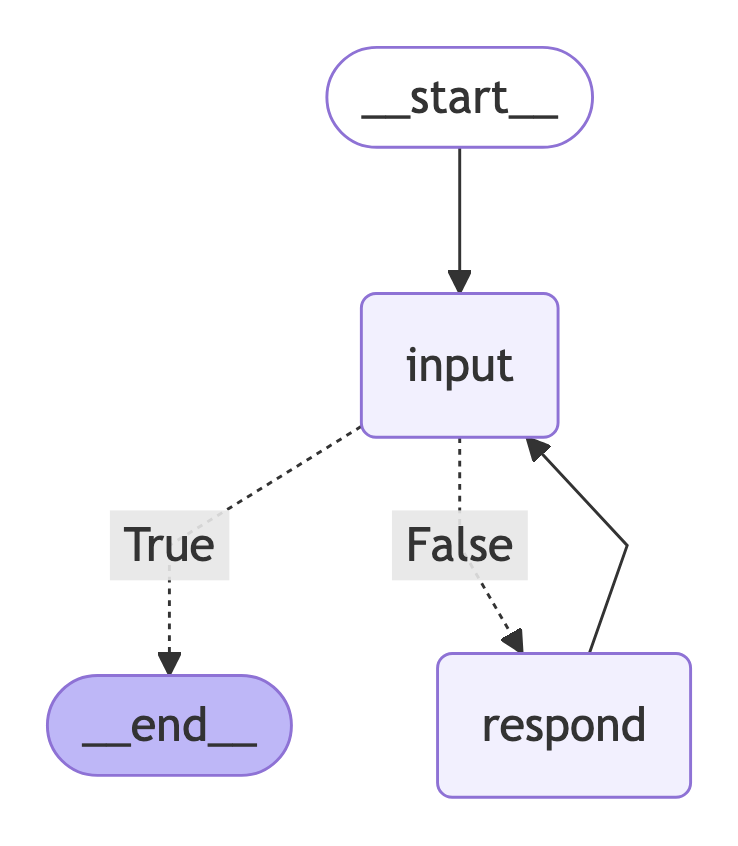

In [15]:
# unstable
try:
    display(
        Image(
            chatbot.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.PYPPETEER
            )
        )
    )
except:
    pass

In a real-life development, you are more likely to want to make a class for the chatbot that will handle all the building at once. Here, we also add a convenient function to run the chatbot.

In [13]:
class Chatbot:

    _graph_path = "./graph.png"
    
    def __init__(self, llm):
        self.llm = llm
        self._build()
        self._display_graph()

    def _build(self):
        # graph builder
        self._graph_builder = StateGraph(State)
        # add the nodes
        self._graph_builder.add_node("input", self._input_node)
        self._graph_builder.add_node("respond", self._respond_node)
        # define edges
        self._graph_builder.add_edge(START, "input")
        self._graph_builder.add_conditional_edges("input", self._is_quitting_node, {False: "respond", True: END})
        self._graph_builder.add_edge("respond", "input")
        # compile the graph
        self._compile()

    def _compile(self):
        self.chatbot = self._graph_builder.compile()

    def _input_node(self, state: State) -> dict:
        user_query = input("Your message: ")
        human_message = HumanMessage(content=user_query)
        n_turns = state["n_turns"]
        # add the input to the messages
        return {
            "messages": human_message,   # this will append the input to the messages
            "n_turns": n_turns + 1,  # and this will rewrite the number of turns
            # "language": ...  # we don't update this field so we just leave it out
        }
    
    def _respond_node(self, state: State) -> dict:
        messages = state["messages"]    # will already contain the user query
        n_turns = state["n_turns"]
        response = self.llm.invoke(messages)
        # add the response to the messages
        return {
            "messages": response,   # this will append the response to the messages
            "n_turns": n_turns + 1,  # and this will rewrite the number of turns
            # "language": ...  # we don't update this field so we just leave it out
        }
    
    def _is_quitting_node(self, state: State) -> dict:
        # check if the user wants to quit
        user_message = state["messages"][-1].content
        return user_message.lower() == "quit"
    
    def _display_graph(self):
        # unstable
        try:
            self.chatbot.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.PYPPETEER,
                output_file_path=self._graph_path
            )
        except Exception as e:
            pass

    # add the run method
    def run(self):
        input = {
            "messages": [
                SystemMessage(
                    content="You are a helpful and honest assistant." # role
                )
            ],
            "n_turns": 0,
            "language": "some_value"
        }
        for event in self.chatbot.stream(input, stream_mode="values"):   #stream_mode="updates"):
            for key, value in event.items():
                print(f"{key}:\t{value}")
            print("\n")

In [17]:
chatbot = Chatbot(llm)

Now we are ready to interact with the chatbot.

In [19]:
chatbot.run()

messages:	[SystemMessage(content='You are a helpful and honest assistant.', additional_kwargs={}, response_metadata={}, id='d6729705-db7a-41bf-8d42-bc45055bc17e')]
n_turns:	0
language:	some_value


messages:	[SystemMessage(content='You are a helpful and honest assistant.', additional_kwargs={}, response_metadata={}, id='d6729705-db7a-41bf-8d42-bc45055bc17e'), HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='03bdb513-e5bd-4311-b1a3-9e20472b4701')]
n_turns:	1
language:	some_value


messages:	[SystemMessage(content='You are a helpful and honest assistant.', additional_kwargs={}, response_metadata={}, id='d6729705-db7a-41bf-8d42-bc45055bc17e'), HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='03bdb513-e5bd-4311-b1a3-9e20472b4701'), AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat? I'm here to assist you with any questions or topics you'd like to discuss.", additional_kwargs={}, res

<h2 id="checkpointing">4. Checkpointing 📍</h2>

Even though our chatbot now conveniently stores and updates the state throughout **one session**, the final state is erased one the system exits. That does not allow for the **repeated** interaction with it. However, in real life, you want to be able to return to the chatbot in some time and be able to proceed where you left off.

To enable that, LangGraph provides a checkpointer for saving the memory. It creates a snapshot of the state locally stored under a unique id. All you need to do is to compile the graph with this memory and pass the id in the config when running the chatbot.

In [30]:
from langgraph.checkpoint.memory import MemorySaver

In [20]:
class ChatbotWithMemory(Chatbot):

    def _compile(self):
        self.chatbot = self._graph_builder.compile(checkpointer=MemorySaver())

    def run(self, user_id):
        input = {
            "messages": [
                SystemMessage(
                    content="You are a helpful and honest assistant."
                )
            ],
            "n_turns": 0,
            "dummy_field": "some_value"
        }
        # add config
        config = {"configurable": {"thread_id": user_id}}
        for event in self.chatbot.stream(input, config, stream_mode="values"):
            # change the output format
            event["messages"][-1].pretty_print()
            print("\n")

In [22]:
chatbot_with_memory = ChatbotWithMemory(llm)

Now compare: first, we run the simple chatbot twice: it doesn't remember the previous session.

In [23]:
# first run
chatbot.run()

messages:	[SystemMessage(content='You are a helpful and honest assistant.', additional_kwargs={}, response_metadata={}, id='910a17a4-24dc-4ebc-9606-426c725429fc')]
n_turns:	0
language:	some_value


messages:	[SystemMessage(content='You are a helpful and honest assistant.', additional_kwargs={}, response_metadata={}, id='910a17a4-24dc-4ebc-9606-426c725429fc'), HumanMessage(content="hi, I'm Max", additional_kwargs={}, response_metadata={}, id='c7ce02fe-32ef-4ee6-86ab-47871e5c83e7')]
n_turns:	1
language:	some_value


messages:	[SystemMessage(content='You are a helpful and honest assistant.', additional_kwargs={}, response_metadata={}, id='910a17a4-24dc-4ebc-9606-426c725429fc'), HumanMessage(content="hi, I'm Max", additional_kwargs={}, response_metadata={}, id='c7ce02fe-32ef-4ee6-86ab-47871e5c83e7'), AIMessage(content="Hi Max! It's nice to meet you. Is there something I can help you with or would you like to chat? I'm all ears!", additional_kwargs={}, response_metadata={'role': 'assistant'

In [24]:
# second run
chatbot.run()

messages:	[SystemMessage(content='You are a helpful and honest assistant.', additional_kwargs={}, response_metadata={}, id='03b8aea9-aa29-4a64-b5b6-230c35c50ea1')]
n_turns:	0
language:	some_value


messages:	[SystemMessage(content='You are a helpful and honest assistant.', additional_kwargs={}, response_metadata={}, id='03b8aea9-aa29-4a64-b5b6-230c35c50ea1'), HumanMessage(content='remember me?', additional_kwargs={}, response_metadata={}, id='4323f12c-5739-43d3-b045-ffee318a48d7')]
n_turns:	1
language:	some_value


messages:	[SystemMessage(content='You are a helpful and honest assistant.', additional_kwargs={}, response_metadata={}, id='03b8aea9-aa29-4a64-b5b6-230c35c50ea1'), HumanMessage(content='remember me?', additional_kwargs={}, response_metadata={}, id='4323f12c-5739-43d3-b045-ffee318a48d7'), AIMessage(content="I'm afraid I don't have personal memories, so I don't recall individual users or conversations. Each time you interact with me, it's a new conversation and I start from a 

The checkpointed chatbot will have the memories from the previous conversations.

In [25]:
# first run
chatbot_with_memory.run("user_1")

================================ System Message ================================

You are a helpful and honest assistant.


================================ Human Message =================================

hi, I'm Max


================================== Ai Message ==================================

Hi Max! It's nice to meet you. Is there something I can help you with or would you like to chat? I'm all ears!


================================ Human Message =================================

quit




In [27]:
# second run
chatbot_with_memory.run("user_1")

================================ System Message ================================

You are a helpful and honest assistant.


================================ Human Message =================================

remember me?


================================== Ai Message ==================================

You're Max, right? We just started chatting a little while ago. What's up?


================================ Human Message =================================

quit




Note that this works as long as you use the same id! That is how you can maintain different conversation history for different users.

In [28]:
# third run
chatbot_with_memory.run("user_2")

================================ System Message ================================

You are a helpful and honest assistant.


================================ Human Message =================================

remember me?


================================== Ai Message ==================================

I'm afraid I don't have personal memories, so I don't recall individual users or conversations. Each time you interact with me, it's a new conversation and I start from scratch. However, I'm happy to chat with you again and help with any questions or topics you'd like to discuss! How can I assist you today?


================================ Human Message =================================

quit




<h2 id="memory">5. Memory Enhancement 💾</h2>

As discussed in [Basic Chatbot](#basic_chatbot), passing the whole history to the chatbot is extremely inefficient. A simple way to handle it would be to set a memory window, e.g. pass only the last 5 messages.

Additionally, we can make stepwise summaries of the previous conversation to make the interaction more efficient while maintaining the reference to the previous chat history. To do so, we need to create an additional node that would check if the messages have piled up already, and one that would create summaries with LLMs and replace the chat history parts with it.

In [15]:
from langchain_core.messages import RemoveMessage

In [ ]:
# prompt template that will return the predefined system message
# and the additional messages you provide to it
# this will be covered in detail at the next lab
summary_template = ChatPromptTemplate.from_messages(
    [
        # will always be returned
        SystemMessage("Make a summary of the following conversation. Return only the summary in 1-2 sentences."),
        # will be replaced by the messages you provide with the key "messages"
        MessagesPlaceholder(variable_name="messages")
    ]
)

In [ ]:
class SummarizingChatbot(Chatbot):

    _graph_path = "./summarizing_graph.png"

    def __init__(self, llm):
        super().__init__(llm)
        self.summary_template = summary_template

    def _build(self):
        # graph builder
        self._graph_builder = StateGraph(State)
        # add the nodes
        self._graph_builder.add_node("input", self._input_node)
        self._graph_builder.add_node("respond", self._respond_node)
        self._graph_builder.add_node("summarize", self._summarize_node)
        # define edges
        self._graph_builder.add_edge(START, "input")
        self._graph_builder.add_conditional_edges("input", self._is_quitting_node, {False: "respond", True: END})
        self._graph_builder.add_conditional_edges("respond", self._summary_needed_node, {True: "summarize", False: "input"})
        self._graph_builder.add_edge("summarize", "input")
        # compile the graph
        self._compile()

    def _summary_needed_node(self, state: State) -> bool:
        return len(state["messages"]) >= 5   # system + 3 turns

    def _summarize_node(self, state: State):
        # will pass the state to the prompt template;
        # the prompt template will match the key "messages"
        # with the messages in the state
        # and will return a sequence of messages
        # consisting of the summarization system message
        # and the sequence of previous messages in the state 
        prompt = self.summary_template.invoke(state)
        response = self.llm.invoke(prompt)
        # now, mark all previous messages for deletion
        messages =  [RemoveMessage(id=m.id) for m in state["messages"][1:]]  # don't remove the system message
        # and add the summary instead
        messages.append(response)
        n_turns = state["n_turns"]
        return {
            "messages": messages,
            "n_turns": n_turns + 1
        }

In [30]:
summarizing_chatbot = SummarizingChatbot(llm)

In [31]:
summarizing_chatbot.run()

messages:	[SystemMessage(content='You are a helpful and honest assistant.', additional_kwargs={}, response_metadata={}, id='dd1fa488-4449-4011-9191-62b84d5eb319')]
n_turns:	0
language:	some_value


messages:	[SystemMessage(content='You are a helpful and honest assistant.', additional_kwargs={}, response_metadata={}, id='dd1fa488-4449-4011-9191-62b84d5eb319'), HumanMessage(content='what city are you from?', additional_kwargs={}, response_metadata={}, id='ecb2ffac-656b-4668-a82c-c857793806c8')]
n_turns:	1
language:	some_value


messages:	[SystemMessage(content='You are a helpful and honest assistant.', additional_kwargs={}, response_metadata={}, id='dd1fa488-4449-4011-9191-62b84d5eb319'), HumanMessage(content='what city are you from?', additional_kwargs={}, response_metadata={}, id='ecb2ffac-656b-4668-a82c-c857793806c8'), AIMessage(content="I'm not from a specific city, as I'm a computer program designed to assist and communicate with users. I don't have a physical presence or a personal